In [7]:
from skimage import io, exposure

import numpy as np
import scipy
import scipy.ndimage
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sched
import time
import gc
import sys
import csv
import pandas as pd

In [8]:
from scipy.fft import ifftn, fftn, fft2, ifft2
import h5py

In [9]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
def MinMaxNormalization(tensor):
    #min max normalization
    v_min, v_max = tensor.min(), tensor.max()
    tensor = (tensor - v_min)/(v_max - v_min)
    return tensor

(28, 28)


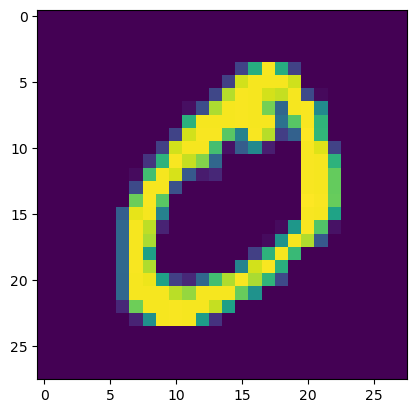

In [11]:
train_data = pd.read_csv("mnist_train.csv", header=None)
train_data = train_data.to_numpy()
img = train_data[1,1:]
img = img.reshape(28,28)
print(img.shape)
plt.imshow(img)

In [13]:
train_x = train_data[:,1:]
train_x = train_x.reshape([train_x.shape[0],1,28,28])
train_y = train_data[:,0]
print(train_x.shape)
print(train_y.shape)

train_x  = torch.from_numpy(train_x).float()
#train_x = train_x.reshape([train_x.shape[0], train_x.shape[1],1,1])
train_y  = torch.from_numpy(train_y).long()
#train_y = train_y.reshape(train_y.shape[0])

t1 = train_x[10000:]
t2 = train_y[10000:]
print(t1.shape)

ted1 = train_x[:10000]
ted2 = train_y[:10000]

(60000, 1, 28, 28)
(60000,)
torch.Size([50000, 1, 28, 28])


# Riesz

In [14]:
def MakeRange(size_n):
    output = np.zeros(size_n)
    center = int(size_n/2)
    for i in range(size_n):
        output[i] = (i-center)/(size_n - (size_n%2))
    return output

In [15]:
def RieszDerivatives(img, order):
    #get image size
    size_x, size_y = img.shape
    Riesz_kernel = np.zeros(img.shape, dtype=complex)
    #get riesz kernel in fourier domain
    gx = MakeRange(size_x)
    gy = MakeRange(size_y)
    for i in range(size_x):
        for j in range(size_y):
            den = gx[i]*gx[i]+gy[j]*gy[j]
            if den > 1e-08:
                if(order[0] == 0 and order[1] == 1):
                    den = np.sqrt(den)
                    Riesz_kernel[i,j] = complex(0,-gy[j]/den)
                if(order[0] == 1 and order[1] == 0):
                    den = np.sqrt(den)
                    Riesz_kernel[i,j] = complex(0,-gx[i]/den)
                if(order[0] == 2 and order[1] == 0):
                    Riesz_kernel[i,j] = complex(gx[i]*gx[i]/den,0)
                if(order[0] == 1 and order[1] == 1):
                    Riesz_kernel[i,j] = complex(gx[i]*gy[j]/den,0)
                if(order[0] == 0 and order[1] == 2):
                    Riesz_kernel[i,j] = complex(gy[j]*gy[j]/den,0)
                    
    #fourier transform of the image
    fft_img = fft2(img)
    fft_img = np.fft.fftshift(fft_img)
    result = np.multiply(fft_img, Riesz_kernel)
    result = np.fft.ifftshift(result)
    result = ifft2(result)
    return result

# Read me:

### Useful links:

We follow tutorial on pytorch:
https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html


How to make parameters to non-trainable?
https://discuss.pytorch.org/t/are-torch-nn-functional-layers-learnable/13687/2


How to implement Gaussian filter?
https://discuss.pytorch.org/t/gaussian-kernel-layer/37619

How to get high-order derivative of Gaussian filter?
https://dsp.stackexchange.com/questions/78280/are-scipy-second-order-gaussian-derivatives-correct

How to concatenate layers?
https://discuss.pytorch.org/t/concatenate-layer-output-with-additional-input-data/20462


### Goal:

implement Gaussian derivative neural network for multiscale analysis from:
Lindeberg, T. Scale-Covariant and Scale-Invariant Gaussian Derivative Networks. J Math Imaging Vis (2021). 
https://doi.org/10.1007/s10851-021-01057-9
or 
https://arxiv.org/abs/2011.14759

Aim: adapt it for multiscale data segmentation of crack in CT images of concrete.




In [16]:
def RieszKernelVar(s_x, s_y, order):
    #get riesz kernel in fourier domain
    size_x = s_x
    size_y = s_y
    Riesz_kernel = np.zeros([size_x, size_y], dtype=complex)
    gx = MakeRange(size_x)
    gy = MakeRange(size_y)
    for i in range(size_x):
        for j in range(size_y):
            den = gx[i]*gx[i]+gy[j]*gy[j]
            if den > 1e-08:
                if(order[0] == 0 and order[1] == 1):
                    den = np.sqrt(den)
                    Riesz_kernel[i,j] = complex(0,-gy[j]/den)
                if(order[0] == 1 and order[1] == 0):
                    den = np.sqrt(den)
                    Riesz_kernel[i,j] = complex(0,-gx[i]/den)
                if(order[0] == 2 and order[1] == 0):
                    Riesz_kernel[i,j] = complex(gx[i]*gx[i]/den,0)
                if(order[0] == 1 and order[1] == 1):
                    Riesz_kernel[i,j] = complex(gx[i]*gy[j]/den,0)
                if(order[0] == 0 and order[1] == 2):
                    Riesz_kernel[i,j] = complex(gy[j]*gy[j]/den,0)
    Riesz_kernel2 = torch.from_numpy(Riesz_kernel)
    Riesz_kernel2= Riesz_kernel2.reshape([1,1,size_x,size_y])
    return Riesz_kernel2

In [17]:
class RieszLayer(nn.Module):
    def __init__(self, order):
        super(RieszLayer, self).__init__()

        self.order = order
        self.size_x = 64
        self.size_y = 64
        self.Riesz_fft = RieszKernelVar(self.size_x,self.size_y, self.order)
 
    def forward(self, x):
        #Riesz_fft = RieszKernel(x, self.order)
        if x.size()[2] != self.size_x or x.size()[3] != self.size_y:
            self.size_x = x.size()[2]
            self.size_y = x.size()[3]
            self.Riesz_fft = RieszKernelVar(self.size_x, self.size_y, self.order)
            

        x = x*self.Riesz_fft

        return x
    
class RieszNet(nn.Module):

    def __init__(self):
        super(RieszNet, self).__init__()
        self.order1 = [1, 0]
        self.order2 = [0, 1]
        self.Rx = RieszLayer(self.order1)
        self.Ry = RieszLayer(self.order2)

    def forward(self, x):

        x = torch.fft.fft2(x)
        x = torch.fft.fftshift(x, dim = [2,3])
        x1 = self.Rx(x)
        x2 = self.Ry(x)
        x3 = -self.Rx(x1)
        x4 = -self.Rx(x2)
        x5 = -self.Ry(x2)
 
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)
        x = torch.fft.ifftshift(x, dim = [2,3])
        x = torch.real(torch.fft.ifft2(x)).double()
        
        return x
    

#12-14-16-20-64 c
class RieszNetDeep(nn.Module):

    def __init__(self):
        super(RieszNetDeep, self).__init__()
        self.conv1 = nn.Conv2d(5,12,kernel_size = (1,1))
        self.conv2 = nn.Conv2d(60,16,kernel_size = (1,1))
        self.conv3 = nn.Conv2d(80,24,kernel_size = (1,1))
        self.conv4 = nn.Conv2d(120,32,kernel_size = (1,1))
        self.conv5 = nn.Conv2d(160,80,kernel_size = (1,1))
        self.conv6 = nn.Conv2d(80,10,kernel_size = (1,1))
        
        self.bn1 = nn.BatchNorm2d(12, affine=True)
        self.bn2 = nn.BatchNorm2d(16, affine=True)
        self.bn3 = nn.BatchNorm2d(24, affine=True)
        self.bn4 = nn.BatchNorm2d(32, affine=True)
        self.bn5 = nn.BatchNorm2d(80, affine=True)
        
        self.GL1 = RieszNet()


    def forward(self, y):
        
        #1st  layer
        x = self.GL1(y)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        #2nd layer
        x = self.GL1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        #3rd layer
        x = self.GL1(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        #4th layer
        x = self.GL1(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        #5th layer
        x = self.GL1(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        #final layer
        x = self.conv6(x)
        x = F.softmax(x)
        x = x[:,:,int(x.shape[2]/2),int(x.shape[2]/2)]
        #print(x.shape)
        return x

# Test

In [18]:
LN = RieszNetDeep()

model = LN.double()

count_parameters(model)

20882

In [ ]:
n_epochs = 20 # or whatever
batch_size = 50 # or whatever
train_num = 50000

optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = sched.StepLR(optimizer, step_size = 7, gamma = 0.5)
criterion_val = loss = nn.CrossEntropyLoss()

#train data
input = t1.double()
target = t2
#validation
input_v = ted1.double()
target_v = ted2


for epoch in range(n_epochs):
    permutation = torch.randperm(train_num)
    if(epoch % 2 == 1):
        print("Epoch:")
        print(epoch)
        print("Train loss:")
        print(t_loss/train_num*batch_size)
        print("val:")
        val_loss=0
        model.eval()
        for i in range(200):
            v1 = model(input_v[(i*50):((i+1)*50)])
            v2  = target_v[(i*50):((i+1)*50)]
 
            val_loss = val_loss + criterion_val(v1,v2)
        print("Validation loss:")
        print(val_loss/10000*50)
        print("--------")
    t_loss = 0
    gc.collect()
    model.train()

    for i in range(0,train_num, batch_size):
        optimizer.zero_grad()
        indices = permutation[i:(i+batch_size)]
        batch_x = input[indices]
        batch_y = target[indices]
        outputs = model.forward(batch_x)
        loss = criterion_val(outputs,batch_y)

        if(epoch % 2 == 0):
            t_loss += loss

        loss.backward()
        optimizer.step()
        gc.collect()

    scheduler.step()
    gc.collect()

C:\Users\barisin\AppData\Local\Temp\ipykernel_8540\2195971149.py:98: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Epoch:
1
Train loss:
tensor(1.5657, dtype=torch.float64, grad_fn=<MulBackward0>)
val:


In [ ]:
torch.save(model.state_dict(), "riesznet-mnist.pth")

In [ ]:
test_data = pd.read_csv("mnist_test.csv")
test_data = test_data.to_numpy()

test_x = test_data[:,1:]
test_x = test_x.reshape([test_x.shape[0],1,28,28])
test_y = test_data[:,0]
print(test_x.shape)
print(test_y.shape)

test_x  = torch.from_numpy(test_x).float()
#test_x = test_x.reshape([test_x.shape[0], test_x.shape[1],1,1])
test_y  = torch.from_numpy(test_y).float()

In [15]:
def accuracy(y1,y2):
    train_acc = torch.sum(y1 == y2)
    final_train_acc = train_acc/y2.shape[0]
    return final_train_acc

In [12]:
#model.load_state_dict(torch.load("riesznet-mnist.pth"))
#model.eval()

RieszNetDeep(
  (conv1): Conv2d(5, 12, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(60, 16, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(80, 24, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(120, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1))
  (conv6): Conv2d(80, 10, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (GL1): RieszNet(
    (Rx): RieszLayer()
    (Ry): RieszLayer()
  )
)

In [13]:
#cast to tensor

In [14]:
gc.collect()

10